In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## WGAN

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
import gzip
torch.cuda.set_device(3)

Download the LSUN scene classification dataset bedroom category, unzip it, and convert it to jpg files (the scripts folder is here in the `dl2` folder):

```
curl 'http://lsun.cs.princeton.edu/htbin/download.cgi?tag=latest&category=bedroom&set=train' -o bedroom.zip
unzip bedroom.zip
pip install lmdb
python lsun-data.py {PATH}/bedroom_train_lmdb --out_dir {PATH}/bedroom
```

This isn't tested on Windows - if it doesn't work, you could use a Linux box to convert the files, then copy them over. Alternatively, you can download [this 20% sample](https://www.kaggle.com/jhoward/lsun_bedroom) from Kaggle datasets.

In [3]:
PATH = Path('data/lsun/')
IMG_PATH = PATH/'bedroom'
CSV_PATH = PATH/'files.csv'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [69]:
files = PATH.glob('bedroom/**/*.jpg')

with CSV_PATH.open('w') as fo:
    for f in files: fo.write(f'{f.relative_to(IMG_PATH)},0\n')

In [5]:
# Optional - sampling a subset of files
CSV_PATH = PATH/'files_sample.csv'

In [79]:
files = PATH.glob('bedroom/**/*.jpg')

with CSV_PATH.open('w') as fo:
    for f in files:
        if random.random()<0.1: fo.write(f'{f.relative_to(IMG_PATH)},0\n')

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        return self.bn(self.relu(self.conv(x)))

In [5]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = []
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

In [6]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.bn(self.relu(self.conv(x)))

In [7]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        self.initial = DeconvBlock(nz, cngf, 4, 1, 0)

        csize, cndf = 4, cngf
        pyr_layers = []
        while csize < isize//2:
            pyr_layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2
        self.pyramid = nn.Sequential(*pyr_layers)

        self.extra = nn.Sequential(*[DeconvBlock(cngf, cngf, 3, 1, 1)
                                    for t in range(n_extra_layers)])

        self.final = nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.pyramid(x)
        x = self.extra(x)
        x = self.final(x)
        return F.tanh(x)

In [8]:
bs,sz,nz = 64,64,100

In [9]:
tfms = tfms_from_stats(inception_stats, sz)
md = ImageClassifierData.from_csv(PATH, 'bedroom', CSV_PATH, tfms=tfms,
                                  skip_header=False, continuous=True)

In [10]:
md = md.resize(128)

A Jupyter Widget

In [11]:
x,_ = next(iter(md.val_dl))

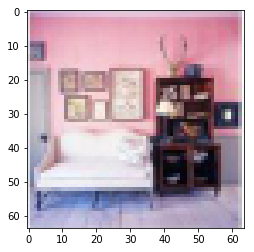

In [38]:
plt.imshow(md.trn_ds.denorm(x)[0]);

In [11]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

In [18]:
def create_noise(b): return V(torch.zeros(b, nz, 1, 1).normal_(0, 1))

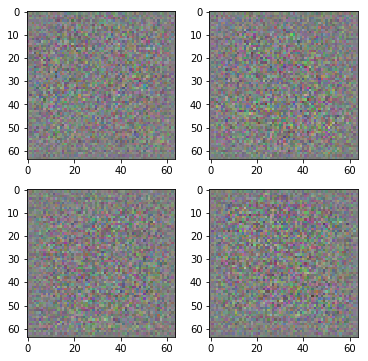

In [13]:
preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

In [12]:
def gallery(x, nc=3):
    n,h,w,c = x.shape
    nr = n//nc
    assert n == nr*nc
    return (x.reshape(nr, nc, h, w, c)
              .swapaxes(1,2)
              .reshape(h*nr, w*nc, c))

In [13]:
netD.load_state_dict(torch.load(TMP_PATH/'netD_2.h5'))
netG.load_state_dict(torch.load(TMP_PATH/'netG_2.h5'))

In [14]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

In [26]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        while i < n:
            set_trainable(netD, True)
            set_trainable(netG, False)
            d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
            j = 0
            while (j < d_iters) and (i < n):
                j += 1; i += 1
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = V(next(data_iter)[0])
                real_loss = netD(real)
                fake = netG(create_noise(real.size(0)))
                fake_loss = netD(V(fake.data))
                netD.zero_grad()
                lossD = real_loss-fake_loss
                lossD.backward()
                optimizerD.step()

            set_trainable(netD, False)
            set_trainable(netG, True)
            netG.zero_grad()
            lossG = netD(netG(create_noise(bs))).mean(0).view(1)
            lossG.backward()
            optimizerG.step()
            gen_iterations += 1
            
        print(f'Loss_D {to_np(lossD)}; Loss_G {to_np(lossG)}; '
              f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')

In [27]:
torch.backends.cudnn.benchmark=True

In [19]:
train(50, False)
# train(50, True)

100%|██████████| 50/50 [22:20:38<00:00, 1608.77s/it]


In [25]:
set_trainable(netD, True)
set_trainable(netG, True)
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-5)

In [29]:
train(10, False)

100%|██████████| 10/10 [4:01:28<00:00, 1448.89s/it]


In [30]:
netD.eval(); netG.eval();

In [31]:
fixed_noise = create_noise(bs)

In [32]:
netD.eval(); netG.eval();
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

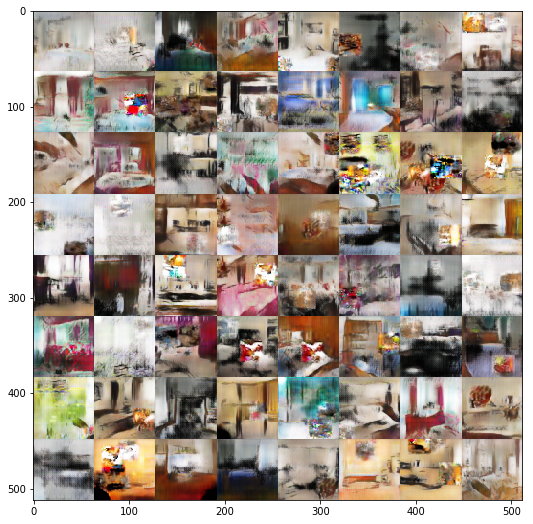

In [35]:
plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));

In [28]:
torch.save(netG.state_dict(), TMP_PATH/'netG_2.h5')
torch.save(netD.state_dict(), TMP_PATH/'netD_2.h5')

## Incomplete upsampling experiments

In [35]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, bn=True):
        super().__init__()
        self.conv = nn.Conv2d(ni, no, ks, 1, padding=ks//2, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = F.upsample(x, scale_factor=2, mode='bilinear')
        return self.bn(self.relu(self.conv(x)))

In [36]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        self.initial = ConvBlock(nz, cngf, 4, 1, pad=3)

        csize, cndf = 4, cngf
        pyr_layers = []
        while csize < isize//2:
            pyr_layers.append(DeconvBlock(cngf, cngf//2, 3))
            cngf //= 2; csize *= 2
        self.pyramid = nn.Sequential(*pyr_layers)

        self.extra = nn.Sequential(*[ConvBlock(cngf, cngf, 3, 1)
                                    for t in range(n_extra_layers)])

        self.final = nn.Conv2d(cngf, nc, 3, 1, 1, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.pyramid(x)
        x = self.extra(x)
        x = F.upsample(x, scale_factor=2, mode='bilinear')
        x = self.final(x)
        return F.tanh(x)

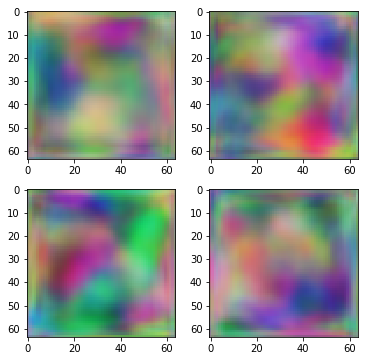

In [38]:
preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

Results after <1 epoch

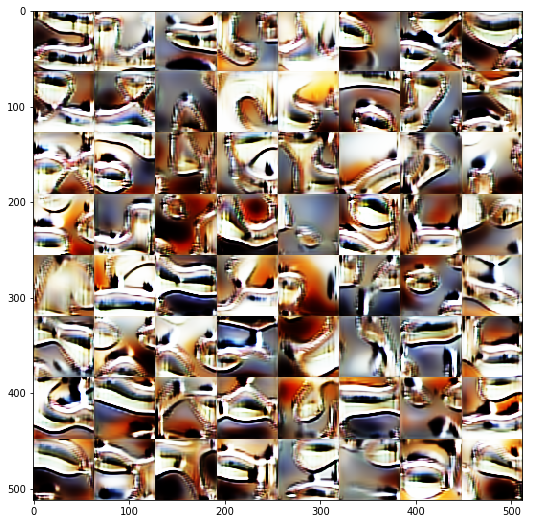

In [47]:
plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));